# Bike Sharing Demand

- 도시 자전거 공유 시스템 사용 예측
- [캐글](https://www.kaggle.com)의 [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand)에서 `train.csv`와 `test.csv`를 다운로드
- 두 파일을 각각 datasets 디렉토리에 bike_train.csv bike_test.csv로 저장 

- 자전거 대여량을 예측하는 문제
- Evaluation : Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). 

## 데이터 탐색 및 전처리

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [12]:
%matplotlib inline
plt.style.use('ggplot')
# 스타일 리스트 출력
#plt.style.available

* [Style 정보](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)

In [3]:
bike_train = pd.read_csv('datasets/bike_train.csv')
bike_test = pd.read_csv('datasets/bike_test.csv')
bike_train.shape

(10886, 12)

* 결측치 확인하기

In [4]:
bike_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
bike_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [7]:
bike_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

* windspeed에 0 값이 생각보다 많음 -> 최솟값으로 대체하기

In [6]:
bike_train['windspeed'].value_counts()

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: windspeed, dtype: int64

datetime: hourly date + timestamp  
season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날  
workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일  
weather:  
• 1 = 맑음, 약간 구름 낀 흐림  
• 2 = 안개, 안개 + 흐림  
• 3 = 가벼운 눈, 가벼운 비 + 천둥  
• 4 = 심한 눈/비, 천둥/번개  
temp: 온도(섭씨)   
atemp: 체감온도(섭씨)  
humidity: 상대습도  
windspeed: 풍속  
casual: 사전에 등록되지 않는 사용자가 대여한 횟수  
registered: 사전에 등록된 사용자가 대여한 횟수  
count: 대여 횟수  

#### 진행할 전처리 과정
* datetime : hour만 추출
* season : 원핫인코딩
* weather : 원핫인코딩
* time : hour 6시간 단위로 카테고리 나눈 후 원핫인코딩
* casual, registered 삭제
* windspeed : 0 -> min값으로 대체

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [10]:
bike_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [209]:
def preprocessing(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['time'] = pd.cut(x=df['hour'], bins=4 , labels=['q1', 'q2', 'q3', 'q4'], include_lowest = True )
    df['windspeed'] = df['windspeed'].replace(0, np.NaN)
    df['windspeed'].fillna(df['windspeed'].min(), inplace=True)
    return df

In [210]:
preprocessing(bike_train)
preprocessing(bike_test)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,time
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,q1
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,6.0032,1,q1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,6.0032,2,q1
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,q1
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,q1
...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,19,q4
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,20,q4
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,21,q4
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,22,q4


In [211]:
cat_pipeline = Pipeline([
    ('cat', OneHotEncoder(sparse=False))
])

In [212]:
cat_attribs = ["season", "weather", "time"]

In [213]:
X_train = bike_train.drop(["datetime", "count", "casual", "registered"], axis=1)
y_train = bike_train["count"]

X_train_tmp = X_train.drop(cat_attribs, axis=1)
X_prepared = cat_pipeline.fit_transform(X_train[cat_attribs])
columns = list(cat_pipeline["cat"].get_feature_names(cat_attribs))
cat_df = pd.DataFrame(X_prepared, columns=columns)
X_train_full = pd.concat([X_train_tmp, cat_df], axis=1)

In [214]:
X_test = bike_test.drop(["datetime"], axis=1)
X_test_tmp = X_test.drop(cat_attribs, axis=1)
X_test_prepared = cat_pipeline.transform(X_test[cat_attribs])
cat_test_df = pd.DataFrame(X_test_prepared, columns=columns)
X_test_full = pd.concat([X_test_tmp, cat_test_df], axis=1)

In [215]:
X_train_full

,holiday,workingday,temp,atemp,humidity,windspeed,hour,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,time_q1,time_q2,time_q3,time_q4
0,0,0,9.84,14.395,81,6.0032,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,9.02,13.635,80,6.0032,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0,9.02,13.635,80,6.0032,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0,9.84,14.395,75,6.0032,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,9.84,14.395,75,6.0032,4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,15.58,19.695,50,26.0027,19,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10882,0,1,14.76,17.425,57,15.0013,20,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10883,0,1,13.94,15.910,61,15.0013,21,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10884,0,1,13.94,17.425,61,6.0032,22,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [216]:
X_test_full

,holiday,workingday,temp,atemp,humidity,windspeed,hour,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,time_q1,time_q2,time_q3,time_q4
0,0,1,10.66,11.365,56,26.0027,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,1,10.66,13.635,56,6.0032,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1,10.66,13.635,56,6.0032,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,1,10.66,12.880,56,11.0014,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1,10.66,12.880,56,11.0014,4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,0,1,10.66,12.880,60,11.0014,19,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6489,0,1,10.66,12.880,60,11.0014,20,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6490,0,1,10.66,12.880,60,11.0014,21,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6491,0,1,10.66,13.635,56,8.9981,22,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


* 모델 학습

* DecisionTreeRegressor

In [20]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_full, y_train)

DecisionTreeRegressor(random_state=42)

In [21]:
param_grid = (
     {'max_depth' : [10, 30, 50, 70, 100], 'min_samples_split' : [2, 3, 4]}
)

In [25]:
grid_search = GridSearchCV(tree_reg, param_grid, cv=5)
grid_search.fit(X_train_full, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [10, 30, 50, 70, 100],
                         'min_samples_split': [2, 3, 4]})

In [26]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test_full)

* RandomForestRegressor

In [225]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_full, y_train)

RandomForestRegressor(random_state=42)

In [226]:
param_grid = (
     {'n_estimators':[50, 100], 'max_depth' : [5, 10], 'min_samples_split' : [3, 4, 5], 'min_samples_leaf' : [3, 4, 5]}
)

In [227]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5)
grid_search.fit(X_train_full, y_train)
grid_search.best_params_

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 100}

In [228]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test_full)

In [229]:
scores = cross_val_score(final_model, X_train_full, y_train, scoring="neg_mean_squared_log_error")
np.sqrt(-scores).mean()

0.5690272778169125

* bagging

In [164]:
from sklearn.ensemble import BaggingRegressor

In [165]:
bag_reg = BaggingRegressor(
    RandomForestRegressor(random_state=42), n_estimators=100, max_samples=100, n_jobs=-1, random_state=42)

bag_reg.fit(X_train_full, y_train)

BaggingRegressor(base_estimator=RandomForestRegressor(random_state=42),
                 max_samples=100, n_estimators=100, n_jobs=-1, random_state=42)

In [166]:
scores = cross_val_score(bag_reg, X_train_full, y_train, scoring="neg_mean_squared_log_error")
np.sqrt(-scores).mean()

0.9179279774208023

* LinearRegressor

In [76]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_full, y_train)

LinearRegression()

In [88]:
scores = cross_val_score(lin_reg, X_train_full, np.log1p(y_train), scoring="neg_mean_squared_error")
np.sqrt(-scores).mean()

0.863279523700465

* SGDRegressor

In [95]:
sgd_reg = SGDRegressor(random_state=42, eta0=0.001, max_iter=10000)
sgd_reg.fit(X_train_full, y_train)

SGDRegressor(eta0=0.001, max_iter=10000, random_state=42)

In [96]:
scores = cross_val_score(sgd_reg, X_train_full, np.log1p(y_train), scoring="neg_mean_squared_error")
np.sqrt(-scores).mean()

0.9299547671243701

* 지금까지 배운 모델들로 학습을 해본 결과 RandomForest가 가장 좋은 성능을 보임
* 모델은 RandomForest로 고정하고 하이퍼파라미터 조정하기

* RandomForest

In [134]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_full, y_train)

RandomForestRegressor(random_state=42)

In [135]:
param_grid = (
     {'n_estimators':[200, 300, 400], 'max_depth' : [8, 10, 12, 14], 'min_samples_split' : [3, 4, 5, 6]}
)

In [136]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5)
grid_search.fit(X_train_full, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [8, 10, 12, 14],
                         'min_samples_split': [3, 4, 5, 6],
                         'n_estimators': [200, 300, 400]})

In [137]:
grid_search.best_params_

{'max_depth': 14, 'min_samples_split': 6, 'n_estimators': 400}

In [138]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test_full)

In [139]:
scores = cross_val_score(final_model, X_train_full, y_train, scoring="neg_mean_squared_log_error")
np.sqrt(-scores).mean()

0.575697229351817

In [230]:
submission = pd.read_csv("datasets/sampleSubmission.csv")

submission["count"] = y_pred

ver = 3
model = "randomforest_windspeeds"
submission.to_csv("datasets/ver_{0}_{1}_submission.csv".format(ver, model), index=False)

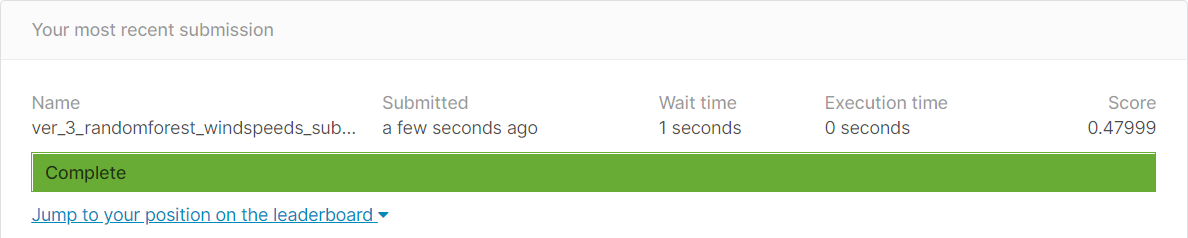

* 느낀점

학습하는데 생각보다 시간이 오래걸려서 다양한 모델로 학습해보지 못한 점이 아쉽다.<br>
하이퍼 파라미터 조정 시 그리드 탐색만 사용했는데 그리드 탐색 후 랜덤 탐색을 썼으면 좀 더 성능을 높일 수 있었을 것 같다.<br>
XGBoost, Adaboost 등 다른 앙상블 모델로 학습을 해봐도 좋을 것 같다.<br>
이번 프로젝트를 통해 가장 크게 느낀점은 모델의 성능 차이보다는 전처리를 어떻게 하느냐에 따라 성능 차이가 많이 난다는 것을 느꼈고 그 부분에 대한 공부가 더 필요하다고 느꼈다.<br>
인터넷에 올라온 코드를 보니 windspeed를 최솟값이나 평균 등으로 채우지 않고 아예 모델 학습 후 예측을 해 채워서 0.41의 성능이 나온 것을 보았다. 특성을 예측하여 채운 후 학습하는 방법은 몰랐는데 새로운 전처리 방법을 배우게 되었다. <br>
처음 전처리를 할 때는 hour로 time 특성을 구한 후 학습을 할 때는 hour를 삭제 후 진행했었는데 hour를 넣어서 학습했을 때가 더 성능이 좋았다.<br>
강사님께서 hour와 time같이 동일한 특성에서 나온 특성을 가지고 학습을 진행하면 다중공선성때문에 성능이 더 안나올 수도 있다고 말씀해주셔서 나중에 time도 삭제하고 다른 특성에 대해서도 전처리를 다시해서 성능을 개선해봐야겠다.<br>